# Build Predictive Model For Post Tags Classification.

## 1. Overview of the Data

- Post data collected from Stack Overflow is analyzed and normalized ([Post-Categorization
/Visualize-Post-Data.ipynb](https://github.com/programmerHoangBao/Post-Categorization.git)) to support building a model that predicts which tags a post belongs to based on its content.
- Data Structure:
  - **Body**: The content of the post is of string data type.
  - **Tags**: The list of tags for the post is of data type 'list'.

## 2. Import libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.pipeline import make_pipeline
import time
import ast
from collections import Counter
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

- **pandas**: Used for processing and analyzing tabular data (DataFrame), with support for reading and writing CSV files.
- **sklearn.model_selection.train_test_split**: Split the data into training and test sets.
- **sklearn.feature_extraction.text.TfidfVectorizer**: Convert text into numerical feature vectors based on word frequency using TF-IDF.
- **sklearn.preprocessing.MultiLabelBinarizer**: Convert label lists into binary matrices for multi-label classification tasks.
- **sklearn.linear_model.LogisticRegression**: Logistic regression algorithm is used for classification tasks.
- **sklearn.svm.LinearSVC**: Linear Support Vector Machine (SVM) model for classification.
- **sklearn.naive_bayes.MultinomialNB**: Naive Bayes classifier is used for discrete data such as text.
- **sklearn.multiclass.OneVsRestClassifier**: Implement the One-vs-Rest strategy for multi-label classification.
- **sklearn.metrics.f1_score**: Evaluate model accuracy based on the F1-score metric.
- **sklearn.metrics.classification_report**: Generate a detailed report including precision, recall, and F1-score for each label.
- **sklearn.pipeline.make_pipeline**: Build a pipeline that integrates preprocessing steps with the training model.
- **time**: Standard Python library for measuring execution time and performance.
- **ast**: Allows you to read, understand, and manipulate Python code as a data structure rather than just text.
- **collections.Counter**: Used to count the frequency of elements in a list or string.
- **itertools.chain**: Used to concatenate multiple iterables (such as lists or tuples) into a single continuous sequence.
- **numpy**: A library that supports high-performance numerical computations, especially with arrays and matrices.
- **matplotlib.pyplot**: A library used for plotting charts and visualizing data.
- **seaborn**: A data visualization library built on top of Matplotlib, designed to create more attractive and understandable charts.
- **joblib**: A library used to save and load large Python objects — especially machine learning models — quickly and efficiently.

## 3. Load data

- Path to the dataset:

In [2]:
input_path = "/kaggle/input/post-tag-classfication/dataset/post.csv"

In [3]:
df_post = pd.read_csv(input_path)

In [4]:
print(df_post.dtypes)
print(f"Number rows: {len(df_post)}")
print(df_post.head(5))

Body    object
Tags    object
dtype: object
Number rows: 204591
                                                Body  \
0  I have a wcf application hosted in a windows s...   
1  I use Delphi for many years, and although I ha...   
2  I have a\nweb-service\n that I will be deployi...   
3  What are the ways that you use to model and re...   
4  Which class design is better and why?\n\npubli...   

                                Tags  
0                ['wcf', 'security']  
1        ['visual-studio', 'delphi']  
2  ['c#', 'asp.net', 'web-services']  
3    ['sql', 'sql-server', 'oracle']  
4                            ['oop']  


In [5]:
print(df_post["Tags"].apply(type).value_counts())

Tags
<class 'str'>    204591
Name: count, dtype: int64


- As you can see, the 'Tags' column is currently of type 'str', so it needs to be converted to a 'list'.

In [6]:
def normalize_tags(tags):
    if pd.isna(tags):
        return []
    if isinstance(tags, str):
        try:
            return ast.literal_eval(tags)
        except (ValueError, SyntaxError):
            return []
    if isinstance(tags, list):
        return tags
    return []

In [7]:
df_post["Tags"] = df_post["Tags"].apply(normalize_tags)

In [8]:
print(df_post["Tags"].apply(type).value_counts())

Tags
<class 'list'>    204591
Name: count, dtype: int64


In [9]:
tag_counter = Counter(chain.from_iterable(df_post["Tags"]))
tag_counts = pd.Series(tag_counter).sort_values(ascending=False)

In [10]:
print("Number of subject: ", len(tag_counts))
print("Top 10 tags:", tag_counts.head(10).to_dict())
print("Bottom 10 tags:", tag_counts.tail(10).to_dict())

Number of subject:  67
Top 10 tags: {'c#': 34409, '.net': 20357, 'java': 17588, 'asp.net': 15644, 'javascript': 12816, 'php': 11955, 'c++': 11926, 'python': 8972, 'sql': 8391, 'jquery': 7943}
Bottom 10 tags: {'eclipse': 1816, 'macos': 1810, 'silverlight': 1794, 'actionscript-3': 1708, 't-sql': 1675, 'language-agnostic': 1627, 'excel': 1606, 'internet-explorer': 1521, 'nhibernate': 1510, 'exception': 1508}


### 3.1 Frequency distribution of tags

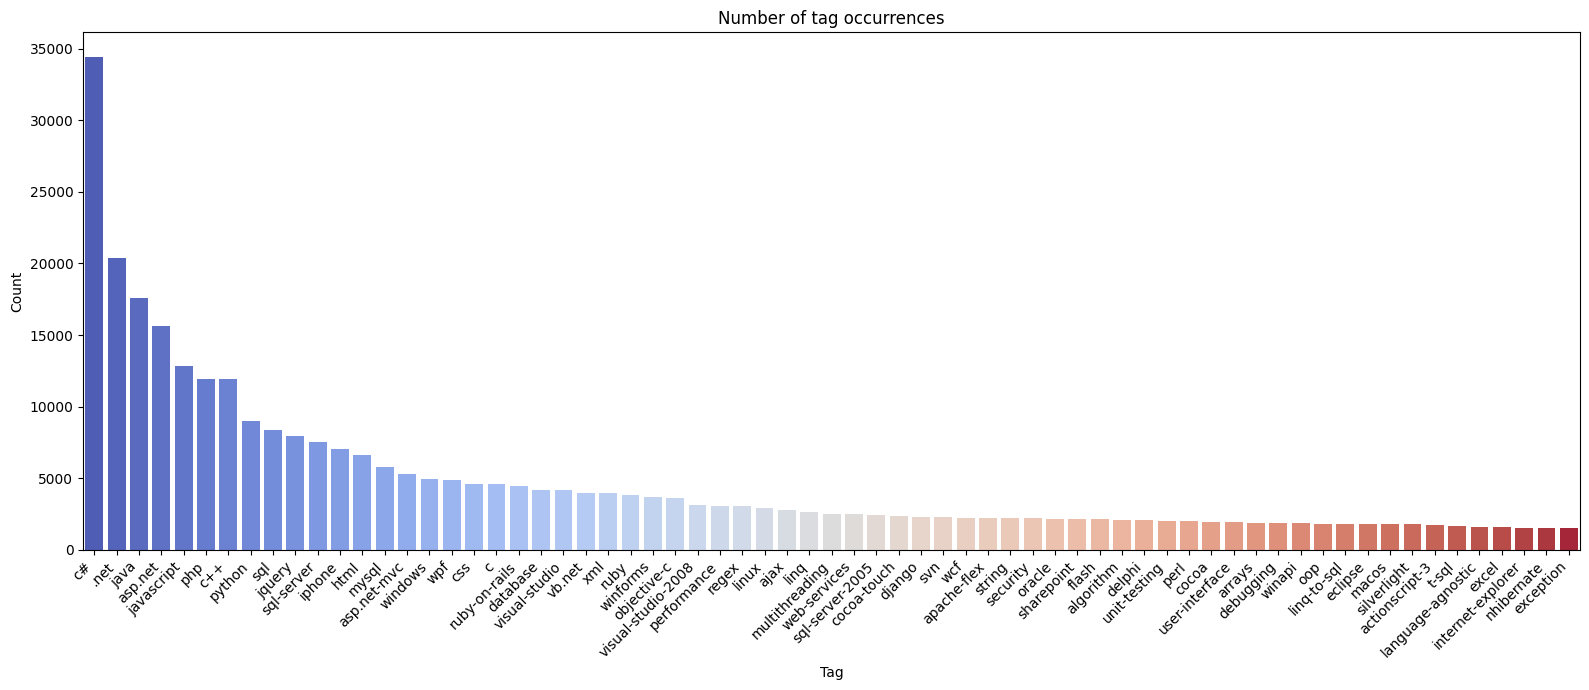

In [11]:
plt.figure(figsize=(16, 7))
sns.barplot(x=tag_counts.index, y=tag_counts.values, palette="coolwarm")
plt.title("Number of tag occurrences")
plt.ylabel("Count")
plt.xlabel("Tag")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Looking at the chart, we can see that **'C#'** has the highest frequency (over 30,000 occurrences), while tags from **'exception'** onward appear fewer than 1600 times. This indicates that the data is imbalanced, which could potentially lead to overfitting.

### 3.2 Average number of tags per post

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


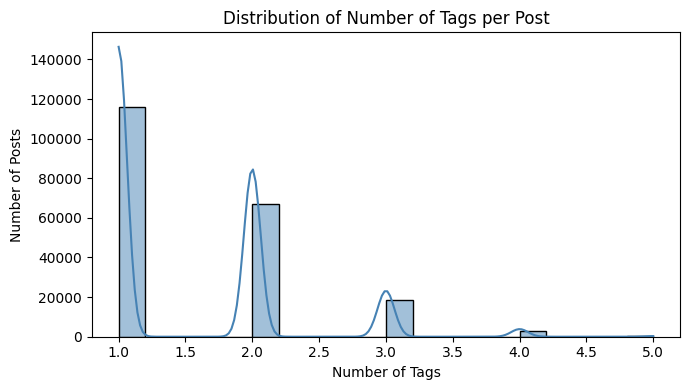

In [12]:
tag_per_post = df_post["Tags"].apply(len)
plt.figure(figsize=(7, 4))
sns.histplot(tag_per_post, bins=20, kde=True, color="steelblue")
plt.title("Distribution of Number of Tags per Post")
plt.xlabel("Number of Tags")
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.show()

- Helps identify that most posts have 1–4 tags (light multi-label), which supports choosing a prediction threshold/OneVsRest.

### 3.3 Post content length (word count)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


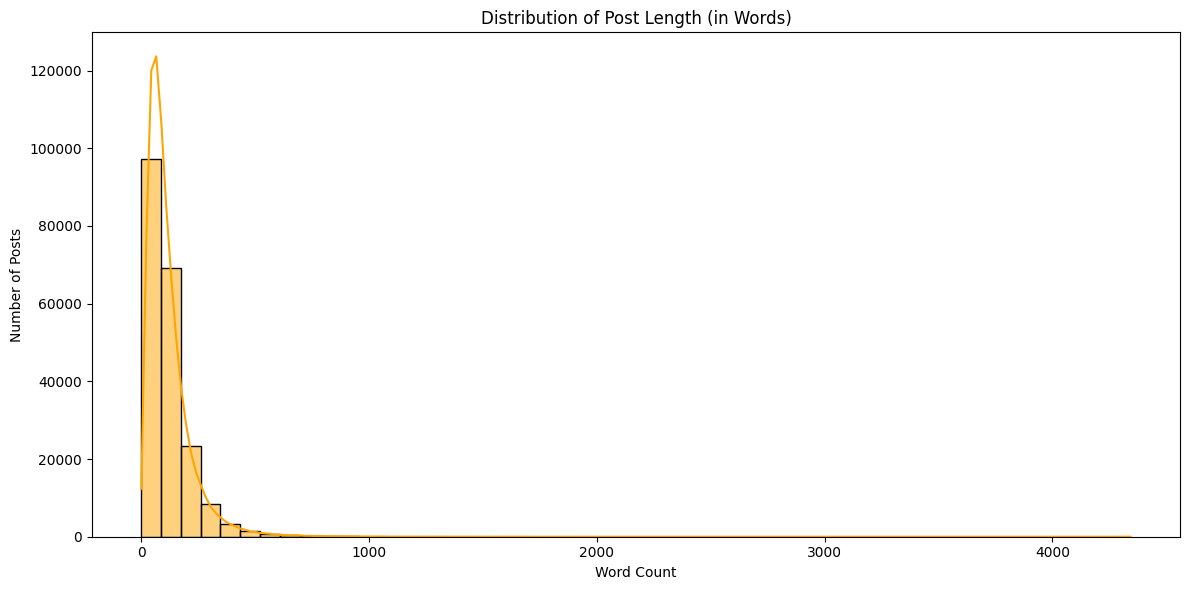

In [13]:
df_post["Body_length"] = df_post["Body"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 6))
sns.histplot(df_post["Body_length"], bins=50, kde=True, color="orange")
plt.title("Distribution of Post Length (in Words)")
plt.xlabel("Word Count")
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.show()

In [14]:
tokenized_posts = df_post['Body'].dropna().apply(lambda x: str(x).lower().split())
word_counts = Counter(word for words in tokenized_posts for word in words)
word_in_posts = Counter()
for words in tokenized_posts:
    for word in set(words):
        word_in_posts[word] += 1
num_posts = len(tokenized_posts)
filtered_words = {
    w for w in word_counts
    if word_counts[w] > 3 and (word_in_posts[w] / num_posts) <= 0.2
}

print(f"🔍 Number of unique meaningful words: {len(filtered_words):,}")
print(f"📝 On average, each post contains {df_post['Body_length'].mean():.0f} words.")

🔍 Number of unique meaningful words: 151,506
📝 On average, each post contains 119 words.


- Looking at the data, we can see that there are 151,506 unique words that appear more than 3 times and in no more than 20% of the posts. Therefore, to ensure accurate model learning, it's recommended to set max_features = 151,506.
- Shows that most posts are short (under 200 words)

### 3.4 Model selection

- The data becomes sparse when vectorized using TF-IDF, so linear models tend to perform well.
- When we transform the data into TF-IDF vectors, algorithms such as Logistic Regression, Linear SVM, and Multinomial Naive Bayes can be applied.

## 4. Prepare training data

- **features (X)**: This is the textual content of the post (the 'Body' column). It serves as the input data from which the model learns to predict labels.
- **labels (y)**: This is a list of tags (topic labels) associated with each post. Since a post can have multiple tags, this is a multi-label classification problem.

In [15]:
X = df_post["Body"]
y = df_post["Tags"]

- **Multi-label encoder**: Convert the lists of tags into a binary matrix (0–1 format).
- **Fit the encoder and apply data transformation**: Learn all the tags present in the data and encode each post accordingly.

In [16]:
mlb = MultiLabelBinarizer()
y_bin = mlb.fit_transform(y)

In [17]:
print(mlb.classes_[:10])
print(y_bin.shape)

['.net' 'actionscript-3' 'ajax' 'algorithm' 'apache-flex' 'arrays'
 'asp.net' 'asp.net-mvc' 'c' 'c#']
(204591, 67)


- Split the dataset into two parts: a training set and a test set.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_bin, test_size=0.2, random_state=42
)

## 5. Define the training and evaluation functions.

- Comprehensive evaluation function — automatically trains the model, measures training time, makes predictions, and computes the F1 score for the classification model.
- **Process Overview**:
  - **Step 1: Display Model Name**
    - Prints a header showing which model is currently being evaluated.
  - **Step 2: Train the Model**
    - Starts a timer to measure how long the training process takes.
    - Fits the model using the provided training data (X_train, y_train).
    - Calculates the total training time in seconds.
  - **Step 3: Make Predictions**
    - Uses the trained model to predict labels for the test dataset (X_test).
    - The predicted values are stored in y_pred.
  - **Step 4: Evaluate Model Performance**
    - Computes two types of F1 scores:
      - **F1-micro**: Evaluates performance globally by counting the total true positives, false negatives, and false positives.
      - **F1-macro**: Evaluates performance by computing the mean F1 score for each class, giving equal weight to all classes.
  - **Step 5: Display Results**
    - Total training time (in seconds)
    - F1-micro score
    - F1-macro score
  - **Step 6: Return Results**
    - Returns a dictionary containing:
    ```json
        {
            "model": "RandomForestClassifier",
            "micro": 0.9123,
            "macro": 0.8867,
            "time": 12.34
        }

In [19]:
def evaluate_model(model, model_name):
    print(f"\n===== {model_name} =====")
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start

    # Prediction
    y_pred = model.predict(X_test)

    # If the model doesn't support probabilities → the output will be labels (OK)
    f1_micro = f1_score(y_test, y_pred, average="micro")
    f1_macro = f1_score(y_test, y_pred, average="macro")

    print(f"Training time: {train_time:.2f}s")
    print(f"F1-micro: {f1_micro:.4f}")
    print(f"F1-macro: {f1_macro:.4f}")
    
    return {"model": model_name, "micro": f1_micro, "macro": f1_macro, "time": train_time}

## 6. Initialize the vectorizer

- Transform text into numerical vectors — specifically TF-IDF vectors — for training machine learning models.
- **_Note_**:
  - Limit to the top 50,000 features (most frequent words/terms) to avoid memory overload and data noise.
  - Use both unigrams (single words) and bigrams (two consecutive words).
    - Example: 'machine learning' → ['machine', 'learning', 'machine learning']
  - Remove English stop words (such as “a”, “the”, “is”, “and”) as they often carry little meaningful information.

In [20]:
tfidf = TfidfVectorizer(
    max_features=151506,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    stop_words="english"
)

## 7. Define the model

- **LogisticRegression**: Logistic regression model, commonly used for binary or multi-class classification.
- **LinearSVC**: Linear SVM model, highly effective for text classification tasks.
- **MultinomialNB**: The Naive Bayes model based on the multinomial distribution is widely used in text classification due to its efficiency and high speed.
- **OneVsRestClassifier**: Since the original SVM only supports binary classification, it needs to be wrapped to handle multiple labels simultaneously.

In [21]:
models = [
    ("Logistic Regression",
     make_pipeline(tfidf, OneVsRestClassifier(LogisticRegression(max_iter=5000, class_weight="balanced", n_jobs=-1)))),
    
    ("Linear SVM",
     make_pipeline(tfidf, OneVsRestClassifier(LinearSVC(class_weight="balanced", max_iter=5000)))),
    
    ("Multinomial NB",
     make_pipeline(tfidf, OneVsRestClassifier(MultinomialNB())))
]

## 8. Training and Evaluation

In [22]:
results = []
for name, model in models:
    results.append(evaluate_model(model, name))


===== Logistic Regression =====
Training time: 800.55s
F1-micro: 0.5741
F1-macro: 0.5720

===== Linear SVM =====
Training time: 534.36s
F1-micro: 0.6209
F1-macro: 0.6130

===== Multinomial NB =====
Training time: 64.82s
F1-micro: 0.1624
F1-macro: 0.0716


## 9. Model Comparison

In [23]:
results_df = pd.DataFrame(results)
best_model = results_df.sort_values(by="micro", ascending=False).iloc[0]

- Visualize Model Comparison

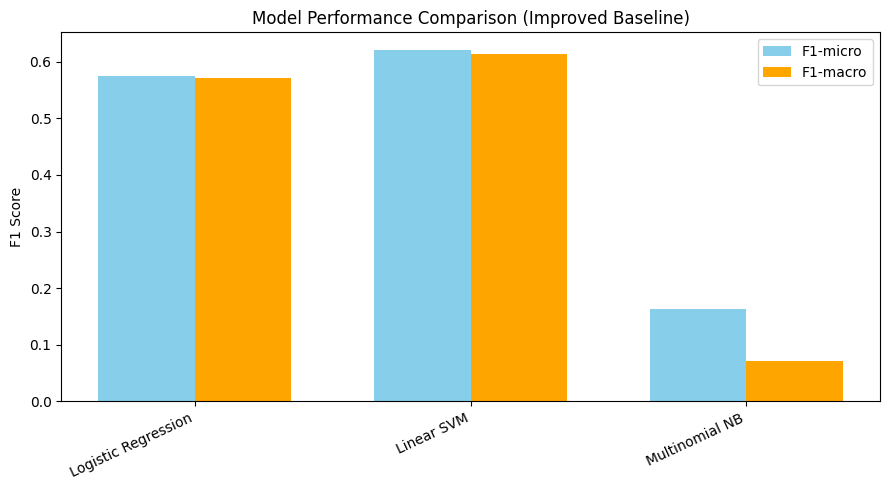

In [24]:
plt.figure(figsize=(9, 5))
x = np.arange(len(results_df))
width = 0.35

plt.bar(x - width/2, results_df["micro"], width, label="F1-micro", color="skyblue")
plt.bar(x + width/2, results_df["macro"], width, label="F1-macro", color="orange")

plt.xticks(x, results_df["model"], rotation=25, ha="right")
plt.ylabel("F1 Score")
plt.title("Model Performance Comparison (Improved Baseline)")
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
print("\n=== 📊 Summary of Results ===")
print(results_df)
print("\n🏆 Best Model:")
print(best_model)


=== 📊 Summary of Results ===
                 model     micro     macro        time
0  Logistic Regression  0.574117  0.572008  800.550940
1           Linear SVM  0.620927  0.613036  534.361319
2       Multinomial NB  0.162351  0.071627   64.819093

🏆 Best Model:
model    Linear SVM
micro      0.620927
macro      0.613036
time     534.361319
Name: 1, dtype: object


## 11. Export the model

In [26]:
best_model_name = best_model["model"]

best_model_obj = None
for name, model in models:
    if name == best_model_name:
        best_model_obj = model
        break

print(f"\n🚀 Re-training best model on full training set: {best_model_name}")
best_model_obj.fit(X_train, y_train)

save_path = f"best_model_{best_model_name.replace(' ', '_')}.joblib"
joblib.dump(best_model_obj, save_path)
print(f"✅ Best model saved to: {save_path}")

joblib.dump(mlb, "label_binarizer.joblib")
print("✅ Label binarizer saved.")



🚀 Re-training best model on full training set: Linear SVM
✅ Best model saved to: best_model_Linear_SVM.joblib
✅ Label binarizer saved.


In [27]:
model = joblib.load("/kaggle/working/best_model_Linear_SVM.joblib")
mlb = joblib.load("/kaggle/working/label_binarizer.joblib")

def predict_tags(text):
    pred = model.predict([text])
    tags = mlb.inverse_transform(pred)
    return tags[0] if tags else []

sample_text = "How can I fix a NullPointerException in Java when using HashMap?"
print("Predicted Tags:", predict_tags(sample_text))

Predicted Tags: ('java',)
